In [133]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import operator
from scipy import mean

In [3]:
routes_df = pd.read_csv("data/routes.csv")
airports_df = pd.read_csv("data/airports.csv")
#print(routes_df.keys())
#print(airports_df.keys())

In [4]:
airports_by_iata_df = airports_df.groupby("IATA")

In [5]:
airports_by_longtitude_df = airports_df.groupby("Longitude")
airports_by_lattitude_df = airports_df.groupby("Latitude")

In [6]:
airport_nodes = list(airports_by_iata_df.groups)

In [31]:
#Ordering matches source and destination airport.
airport_src = list(routes_df["Source airport"])
airport_dest = list(routes_df["Destination airport"])

In [32]:
airport_routes_digraph = nx.MultiDiGraph()

airport_routes_digraph.add_nodes_from(airport_nodes)

edges = [(airport_src[i],airport_dest[i]) for i in range(len(airport_src))
        if airport_src[i] in airport_nodes and airport_dest[i] in airport_nodes
        ]

'''
for edge in edges:
    if edge[0] not in airport_nodes or edge[1] not in airport_nodes:
        edges.remove(edge)
        print(edge in edges)
'''

airport_routes_digraph.add_edges_from(edges);


## Cleaning up, making the graph weakly connected

In [33]:
airport_nodes_weakly = [n for n in airport_nodes if n in airport_src or n in airport_dest]

airport_routes_digraph_weakly = nx.MultiDiGraph()

airport_routes_digraph_weakly.add_nodes_from(airport_nodes_weakly)
airport_routes_digraph_weakly.add_edges_from(edges);

# Average shortest path 

In [34]:
airport_undirected = nx.to_undirected(airport_routes_digraph_weakly)
nx.is_connected(airport_undirected)

subgraphs = nx.connected_component_subgraphs(airport_undirected)

print "Edges in graph: " + str(airport_undirected.number_of_edges())
print "Nodes in graph: " +  str(airport_undirected.number_of_nodes())
big_subgraph = max(subgraphs,key=lambda x: x.number_of_edges())

print
print "Edges in subgraph: " + str(big_subgraph.number_of_edges())
print "Nodes in subgraph: " +  str(big_subgraph.number_of_nodes())

Edges in graph: 65837
Nodes in graph: 3173

Edges in subgraph: 33793
Nodes in subgraph: 3138


In [35]:

print "The average shortest path through out our network is: " + str(nx.average_shortest_path_length(big_subgraph))

The average shortest path through out our network is: 3.96032083199


# Longest Shortest Path

In [36]:
shortest_path_lengths = sorted([(k, max(zip(v.values(), v.keys()))) for k,v in tqdm(nx.shortest_path_length(big_subgraph))],key=lambda x: x[1][0],reverse=True)[:10]

### The shortest paths

In [42]:
paths = []
for item in shortest_path_lengths:
    paths.append(nx.shortest_path(big_subgraph,source=item[0],target=item[1][1]))

In [43]:
print paths[0]
for p in paths[0]:
    print airports_by_iata_df.get_group(p).iloc[0]['Name']

['PTJ', 'MEB', 'FLS', 'LST', 'BNE', 'TPE', 'YYZ', 'YTS', 'YMO', 'YFA', 'ZKE', 'YAT', 'YPO']
Portland Airport
Melbourne Essendon Airport
Flinders Island Airport
Launceston Airport
Brisbane International Airport
Taiwan Taoyuan International Airport
Lester B. Pearson International Airport
Timmins/Victor M. Power
Moosonee Airport
Fort Albany Airport
Kashechewan Airport
Attawapiskat Airport
Peawanuck Airport


In [47]:
edgeys = []
for i in range(0,len(paths[0])-1):
    edgeys.append((paths[0][i],paths[0][i+1]))

In [48]:
def getLongitudeForIATA(df,IATA):
    result = list(df.loc[df['IATA'] == IATA]["Longitude"])
    if(len(result) > 0):
        return result[0]
    else:
        return 0

def getLatitudeForIATA(df,IATA):
    result = list(df.loc[df['IATA'] == IATA]["Latitude"])
    if(len(result) > 0):
        return result[0]
    else:
        return 0

positions = {}

for node in airport_undirected.nodes:
    positions.update({node:(getLongitudeForIATA(airports_df,node),getLatitudeForIATA(airports_df,node))})    
    
options = {
    'width': 0.2,
    'alpha': 0.9,
    'node_size': 50,
    'with_labels': False
}

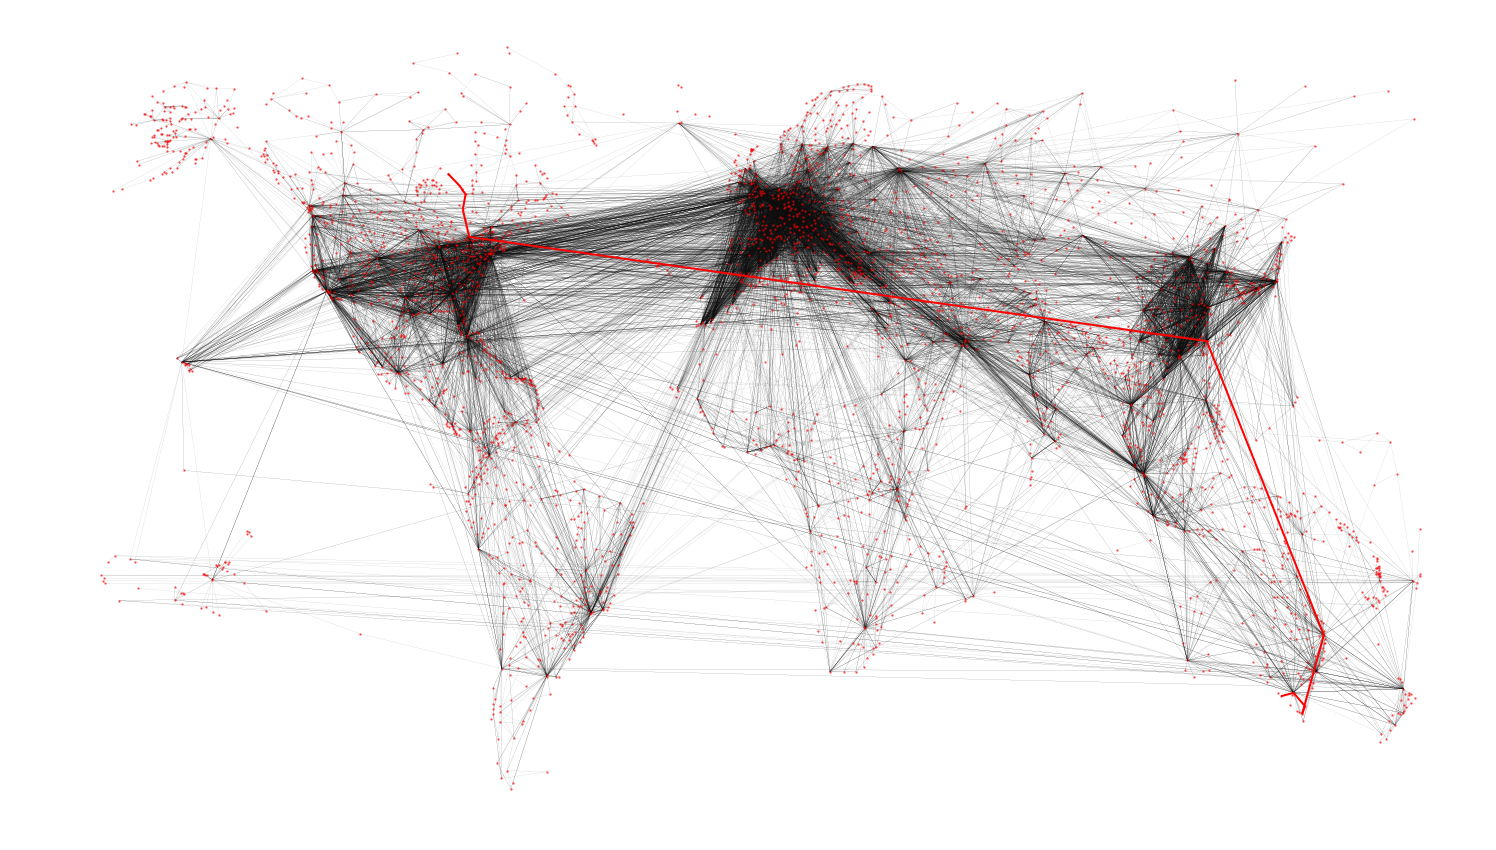

In [61]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_undirected, positions, 
                 width=0.1,alpha=0.5,node_size=2,with_labels=False, 
                 ax=fig.add_subplot(111))
nx.draw_networkx_edges(airport_undirected,positions, edgelist=edgeys, width = 2, alpha = 1, edge_color='r')
plt.axis('off')
fig.show()

In [62]:
fig.savefig("output/longest_shortest_path.png")

In [51]:
d = dict(nx.degree(big_subgraph))

## Node size in terms of node degree

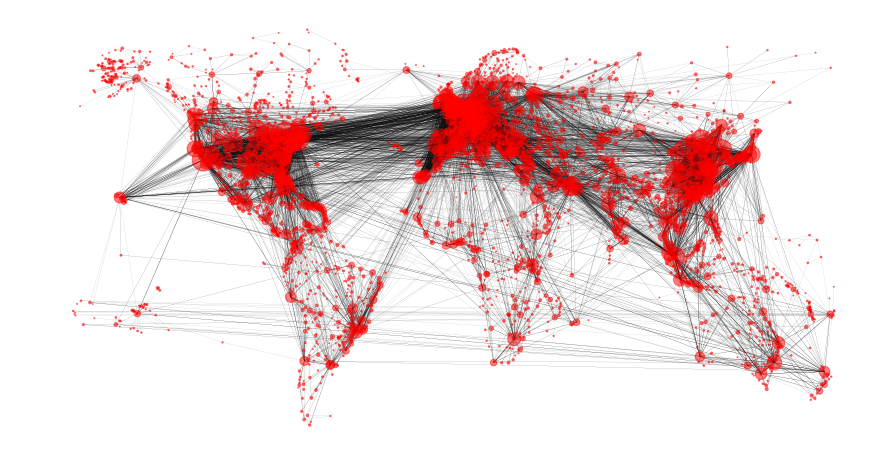

In [63]:
fig_degree = plt.figure(figsize=[15,8])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=d.keys(),
                 node_size=[v * 1 for v in d.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 0.5,
                )
plt.axis('off')
fig_degree.show()

In [64]:
fig_degree.savefig("output/graph_degree_size.png")

## Node size in terms of betweenness centrality

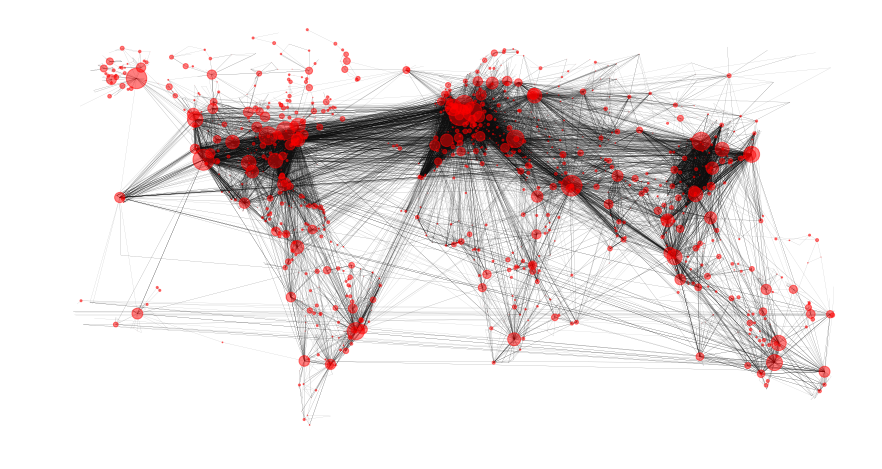

In [65]:
bc = nx.betweenness_centrality(big_subgraph)
fig_betweeness = plt.figure(figsize=[15,8])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=d.keys(),
                 node_size=[v * 7000 for v in bc.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 0.5,
                )
plt.axis('off')
fig_betweeness.show()

In [66]:
fig_betweeness.savefig("output/graph_betweeness_centrality.png")

## Node size in terms of eigenvector centrality

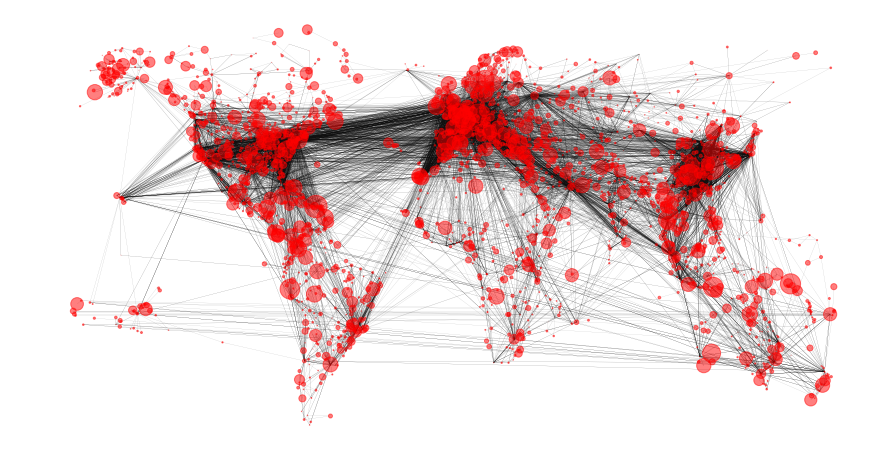

In [84]:
ec = nx.eigenvector_centrality(nx.Graph(big_subgraph))
fig_eigen = plt.figure(figsize=[15,8])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=d.keys(),
                 node_size=[v * 3000 for v in ec.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 0.5,
                )
plt.axis('off')
fig_eigen.show()

In [85]:
fig_eigen.savefig("output/graph_eigenvector_centrality.png")

## Airports with the most connections (highest degree)

In [55]:
top_airports_degree = sorted(d.iteritems(),key = lambda (k,v):(v,k),reverse=True)[:10]
for ai,de in top_airports_degree:
    print (airports_by_iata_df.get_group(ai).iloc[0]['Name'], de)

('Hartsfield Jackson Atlanta International Airport', 932)
("Chicago O'Hare International Airport", 557)
('Charles de Gaulle International Airport', 535)
('London Heathrow Airport', 529)
('Beijing Capital International Airport', 523)
('Los Angeles International Airport', 506)
('Frankfurt am Main International Airport', 498)
('Amsterdam Airport Schiphol', 475)
('Dallas Fort Worth International Airport', 474)
('John F Kennedy International Airport', 459)


## Airports with the highest betweeness centrality

In [56]:
top_airports_betweenness = sorted(bc.iteritems(),key=lambda(k,v):(v,k),reverse=True)[:10]
for ai, be in top_airports_betweenness:
    print (airports_by_iata_df.get_group(ai).iloc[0]['Name'], be)

('Charles de Gaulle International Airport', 0.06511799752869661)
('Los Angeles International Airport', 0.06257423899066704)
('Dubai International Airport', 0.060623094185427155)
('Ted Stevens Anchorage International Airport', 0.05971268196841229)
('Frankfurt am Main International Airport', 0.054207303086621)
('Amsterdam Airport Schiphol', 0.05189224635823235)
('Beijing Capital International Airport', 0.04843164671050269)
("Chicago O'Hare International Airport", 0.047283166023850125)
('Lester B. Pearson International Airport', 0.04612367798334807)
('Atat\xfcrk International Airport', 0.04374701757809472)


## Airports with the highest eigenvector centralities

In [57]:
top_airports_eigenvector = sorted(ec.iteritems(),key=lambda(k,v):(v,k),reverse=True)[:10]
for ai, ee in top_airports_eigenvector:
    print (airports_by_iata_df.get_group(ai).iloc[0]['Name'], ee)

('Amsterdam Airport Schiphol', 0.16807029224473813)
('Frankfurt am Main International Airport', 0.16664054046814633)
('Charles de Gaulle International Airport', 0.16004376555719468)
('Munich International Airport', 0.14886703903632956)
('Leonardo da Vinci\x96Fiumicino Airport', 0.13664266408801487)
('London Heathrow Airport', 0.13600007575946021)
('Atat\xfcrk International Airport', 0.12859353718754477)
('Barcelona International Airport', 0.12847701290238536)
('Z\xfcrich Airport', 0.12595211825232527)
('Adolfo Su\xe1rez Madrid\x96Barajas Airport', 0.1236804346589473)


# Analysis of graph i terms of sentiment

In [122]:
Airport_Name_IATA = {}
for _,row in airports_df.iterrows():
    Airport_Name_IATA[row['Name']] = row['IATA']

In [130]:
import unicodecsv as csv
import codecs
'''
def unicode_csv_reader(utf8_data, dialect=csv.excel, **kwargs):
    csv_reader = csv.reader(utf8_data,delimiter='\t', dialect=dialect, **kwargs)
    for row in csv_reader:
        yield [unicode(cell, 'utf-8') for cell in row]
'''
sentiment_dict= {}
with open("output/airport_sentiment.csv") as csv_file:
    csv_reader = csv.reader(csv_file,delimiter='\t',encoding='utf-8')
    linecount = 0
    for row in csv_reader:         
        
        if linecount != 0 and row[0] in Airport_Name_IATA:
            iata = Airport_Name_IATA[row[0]]
            if iata in big_subgraph.nodes():
                sentiment_dict[iata] = float(row[1])
        linecount += 1
        

C:\Users\linde\Anaconda2\lib\site-packages\ipykernel_launcher.py:15: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  from ipykernel import kernelapp as app


In [139]:
print sentiment_dict

{'AGN': 6.455609055389056, 'AGF': 6.305501541514042, 'AGB': 5.866761416083915, 'AGA': 5.88622101010101, 'NYU': 6.312547619602619, 'NYK': 6.240201832611834, 'NYI': 5.908377546897547, 'NYO': 6.160867331002331, 'AGX': 6.303243716283716, 'XBE': 6.111812041847043, 'AGT': 6.5087462925962924, 'AGS': 6.186918755688755, 'AGR': 6.19101038961039, 'KYK': 6.47832476967477, 'SRY': 6.342522366522365, 'BWT': 6.383225152347653, 'SPP': 6.32573937846665, 'KYA': 6.024474992229991, 'SPS': 6.260418863913864, 'SPU': 6.517156106116106, 'BWA': 6.295590382950385, 'PKA': 6.580696269841272, 'SPN': 6.829506937506937, 'BWI': 6.196931796536797, 'SPC': 5.919683549783549, 'SPD': 6.1883853896103895, 'BWN': 6.184725432900432, 'IXJ': 6.185260165945167, 'IXL': 6.176845086580086, 'IXM': 6.277453716283715, 'IXB': 6.166346132756133, 'IXC': 6.194449783549785, 'IXA': 6.359321349206349, 'IXG': 6.3605800396825405, 'IXD': 6.19101038961039, 'IXE': 6.277453716283715, 'IXZ': 6.268843001998001, 'BYO': 6.367097505272506, 'NYT': 6.4454

In [165]:
sentiment_mean = mean(sentiment_dict.values())
sentiment_min = min(sentiment_dict.values())
sentiment_max = max(sentiment_dict.values())
print sentiment_mean
print sentiment_min
print sentiment_max

6.258366111588227
5.60516568543
6.82950693751


In [261]:
color_map = []
def convert_to_hex(rgba_color) :
    red = int(rgba_color[0]*255)
    green = int(rgba_color[1]*255)
    blue = int(rgba_color[2]*255)
    return '#%02x%02x%02x' % (red, green, blue)

for n in sentiment_dict.values():
    if n <= sentiment_mean:
        color_map.append(convert_to_hex([1,(sentiment_mean-sentiment_min)-(sentiment_mean-n),(sentiment_mean-sentiment_min)-(sentiment_mean-n)]))
    else:
        color_map.append(convert_to_hex([(sentiment_max-sentiment_mean)-(n-sentiment_mean),1,(sentiment_max-sentiment_mean)-(n-sentiment_mean)]))

## Most positive airports

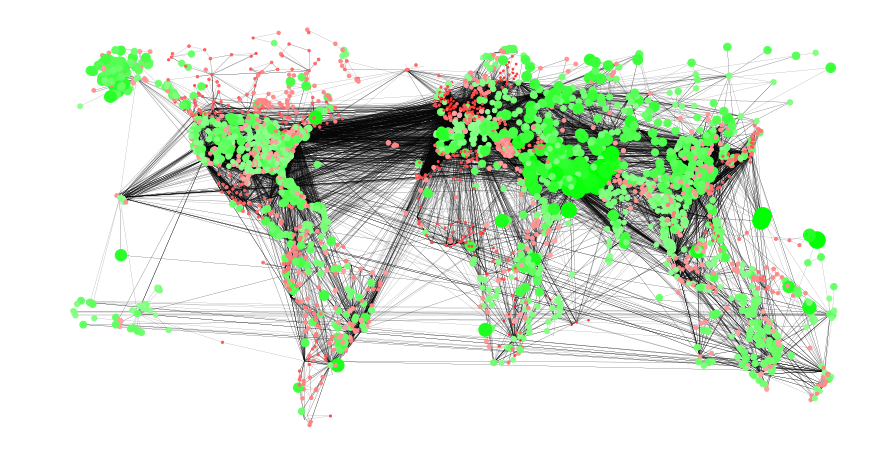

In [265]:
fig_positive = plt.figure(figsize=[15,8])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ 100**(v - sentiment_min) for v in sentiment_dict.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_positive.show()

In [298]:
fig_positive.savefig("output/graph_positive_sentiment_airports.png")

## Most negative airports

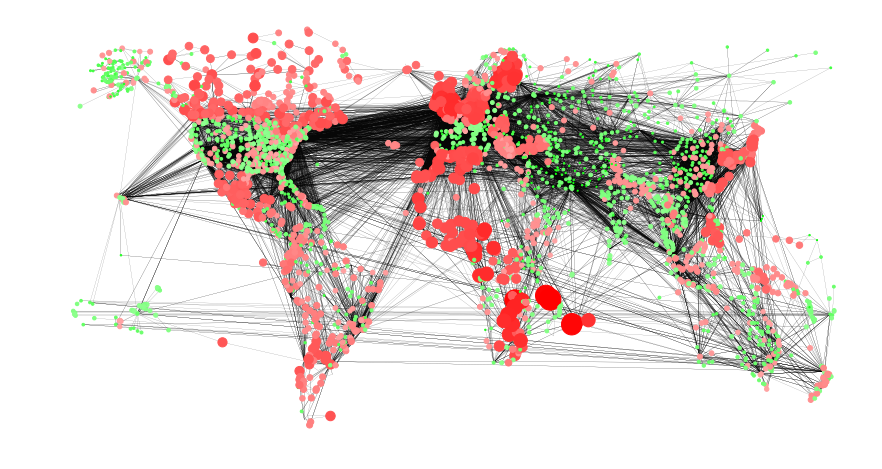

In [299]:
fig_negative = plt.figure(figsize=[15,8])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ 150**(sentiment_max - v) for v in sentiment_dict.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_negative.show()

In [300]:
fig_negative.savefig("output/graph_negative_sentiment_airports.png")

## Negative airports with high degree

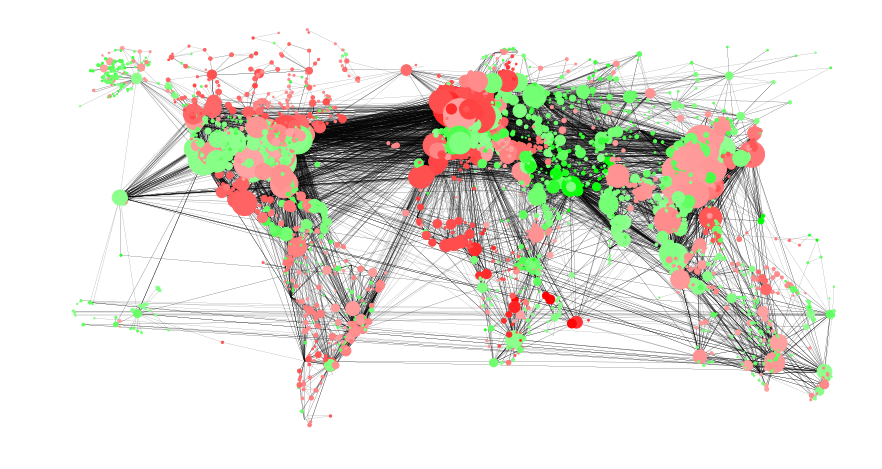

In [267]:
fig_negative_degree = plt.figure(figsize=[15,8])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ (3**(sentiment_max - v))*d[k] for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_negative_degree.show()

In [301]:
fig_negative_degree.savefig("output/graph_negative_sentiment_degree_airports.png")

## Positive airports with high degree

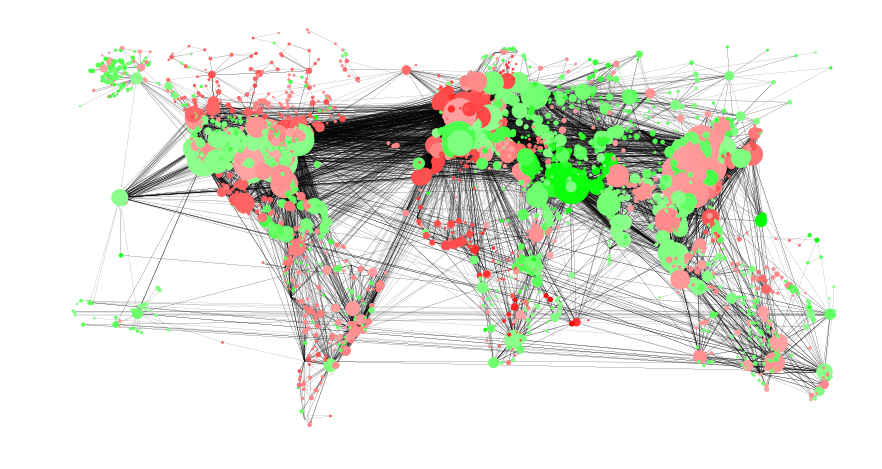

In [270]:
fig_positive_degree = plt.figure(figsize=[15,8])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ (3**(v - sentiment_min))*d[k] for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_positive_degree.show()

In [302]:
fig_positive_degree.savefig("output/graph_positive_sentiment_degree_airports.png")

## Absolute sentiment

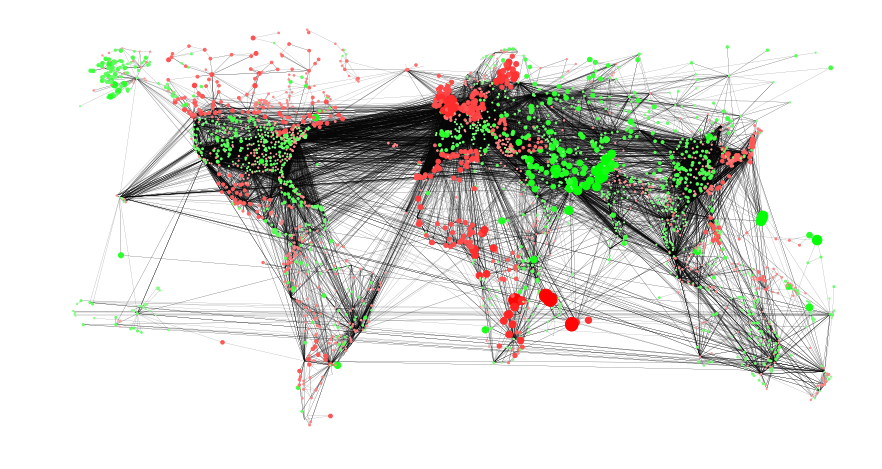

In [271]:
fig_absolute = plt.figure(figsize=[15,8])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ 3000**abs(v - sentiment_mean) for v in sentiment_dict.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute.show()

In [303]:
fig_absolute.savefig("output/graph_absolute_sentiment.png")

## Absolute sentiment vs. degree

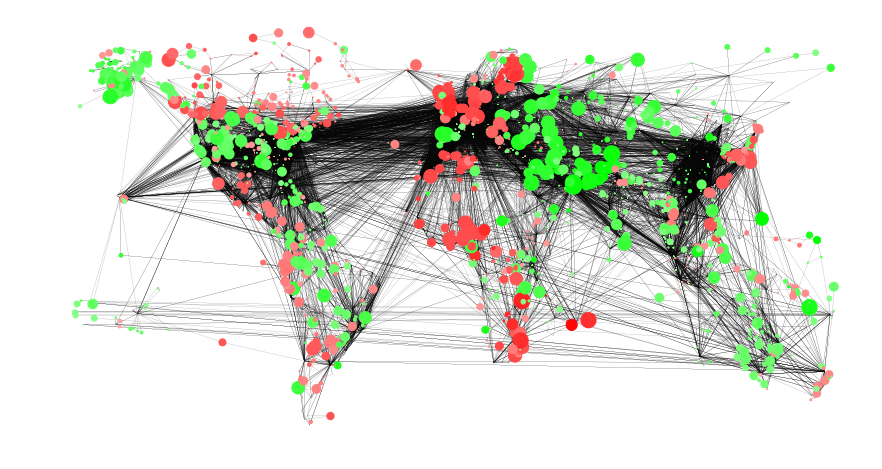

In [292]:
fig_absolute_degree = plt.figure(figsize=[15,8])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ (abs(v - sentiment_mean))**(d[k])*500 for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute_degree.show()

In [ ]:
fig_absolute_degree.savefig("output/graph_")